# Three-body bound state problem

The solution for the three-body bound state problem will again be based on OBEpot classes. 
Therefore, we repeat the methods for defining interaction and for fitting the interaction to the 
given bound state energy.

## Define a two-body interaction

I will work with a class that provides a method for the partial wave projection $V(p,p',l)$ of a bosonic 
interaction.   

A realistic test case is given by a OBE exchange interaction 
$$ V(\vec p, \vec p') = \frac{A}{2\pi} \frac{1}{(\vec p - \vec p')^2 + m_B^2} \exp\left(-\frac{(\vec p - \vec p')^2 + m_B^2}{\Lambda^2 }\right) + \frac{C_0}{4 \pi } \exp\left( - \frac{p^2+{p'}^2}{\Lambda^2}\right) $$ 


In [1]:
import numpy as np
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d
from scipy.special import legendre
import sympy
# definition of a ThreeBody class for the calculation of bound states
from scipy.special import sph_harm
from sympy.physics.quantum.cg import CG
from sympy.physics.quantum.cg import CG, wigner_9j, wigner_6j
from sympy.physics.wigner import clebsch_gordan

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre


class Onepi:
    # this are common parameters for all instances
    hbarc=197.327
    fpi=92.4/hbarc
    ga=1.29

    def __init__(self, cutoff=500.0, C0=1.0, C1=1.0, nx=12,mpi=138.0):
        # defines the one pion exchange for a given regulator and short distance parameter
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.C1=C1
        self.nx=nx
        self.xp,self.xw=leggauss(self.nx)



    def _g(self,pp,p,k,f):
        # calculates g for angular momentum k and power in q f (see expression in PRC 72,054006 (2005))
        # pp outgoing momentum
        # p incoming momentum

        # define prefact
        prefact=np.sqrt(2*k+1.)/2*(-1)**k*4*m.pi
        # get the corresponding legendre polynomial
        Pk = legendre(k)
        # define momentum transfer dependent on angles
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)

        return prefact*np.sum(Pk(self.xp)*qval**(2-f)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2))


    def v(self,pp,p,ll,l,s,j):
        # define the potential (see expression in PRC 72,054006 (2005))

        # first overall prefact of 1pi exchange part
        prefact=-1/(2*m.pi)**3*(self.ga/(2*self.fpi))**2

        #determine isospin depending on partial wave
        if (l+s)%2==0:  # even l+s
          t=1
          tautau=1.0
        else:
          t=0
          tautau=-3.0

        mat=0.0
        if (ll+l)%2==0:  # parity unchanged
          for f in [0,2]:
            factf=prefact*tautau*(3*np.sqrt((2*f+1)/(4*m.pi))  \
                 *wigner_9j(1, 1, f, 1, 1, f, 0, 0, 0) \
                 *float(clebsch_gordan(1,1,f,0,0,0).doit()) \
                 *np.sqrt((2*j+1)*(2*ll+1)*(2*s+1))*wigner_9j(j, j, 0, ll, l, f, s, s, f) \
                 *(-1)**l*6*np.sqrt((2*f+1)/(2*ll+1)*(2*s+1))*(2*f+1) \
                 *wigner_9j(s, s, f, 1/2, 1/2, 1, 1/2, 1/2, 1))
         #   if (l + ll ==2):
         #     print('fatcf: ', l,ll, f,
          #        (CG(1,1,f,0,0,0).doit()),
          #         clebsch_gordan(1,1,f,0,0,0).doit()) \

            for lam1 in range(f+1):
              lam2=f-lam1
              factlam=factf \
                *np.sqrt(4*m.pi*m.factorial(2*f+1.)/(m.factorial(2*lam1)*m.factorial(2*lam2))) \
                *pp**lam1*(-p)**lam2

              for k in range(max(abs(ll-lam1),abs(l-lam2)),min(ll+lam1,l+lam2)+1):
                factk=factlam* wigner_9j(k, k, 0., lam1, lam2, f, ll, l, f)*(2*k+1) \
                           *float(clebsch_gordan(k,lam1,ll,0,0,0).doit())*\
                           float(clebsch_gordan(k,lam2,l,0,0,0).doit())
                mat+=factk*self._g(pp,p,k,f)

        if (ll==0 and l==0 and s==0 and j==0):   # add 1S0 counter term
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)

        if (ll==0 and l==0 and s==1 and j==1):   # add 1S0 counter term
          mat+=self.C1*np.exp(-(pp**2+p**2)/self.cutoff**2)

        return mat

In [2]:
class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential.

       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the
       interaction and the couter term is given on initialization.
       The interaction is regularized using a cutoff that is also
       given on init.
    """

    # this are common parameters for all instances
    hbarc=197.327

    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter

        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave)
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""

        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx

        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)



    # function defines the x integral
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE.

           pp -- outgoing momentum
           p -- incoming momentum
           k -- angular momentum"""

        # define prefact
        # get the corresponding legendre polynomial
        Pk = legendre(k)
        # define momentum transfer dependent on angles
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)


        # build integral of regularized OBE
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))

    # determines complete, regularized interaction
    def v(self,pp,p,l,ll,s,j):
        """Potential matrix element in fm**2

           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum"""

        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A

        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0

        return mat

We use the fits of the last lecture to determine the parameters of this OBE interaction. 

In [3]:
parasets=[[300.0, -0.09827953494014054],
 [400.0, -0.028203145146196713],
 [500.0, -0.0004221894040945335],
 [600.0, 0.012857431330421717],
 [700.0, 0.020167185806378923],
 [800.0, 0.024707945457255083],
 [900.0, 0.027865200396659445],
 [1000.0, 0.030308007813785776],
 [1100.0, 0.03239034331482156],
 [1200.0, 0.03431611357447293]]

## Repeat the two-body bound state solver
The class for the calculation of the two-body bound state is added to check parameters and to provide 
the grid definitions for the two-body t-matrix. 

In [4]:
import numpy as np 
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d

class TwoBody:
    """Methods to obtain eigenvalues and eigenvectors for the bound state problem and for searches of the binding energy."""
    # define hbarc for unit conversion 
    hbarc=197.327  
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,j12=0,s12=0,t12=0,potential=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0,
                            np1four=200,np2four=100):
        """Initialization of two-body solver.

           The initialization defines the momentum grids and the interaction and partial wave to be used.
           At this time, also the grid for Fourier transformation and for the Fourier transformed
           wave function is given.

           Parameters:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of grid points in interval [0,pb]
           np2 -- number of grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above
           pc  -- upper integration boundary for the solution of the integral equation
           mred -- reduces mass of the two bosons in MeV

           nr1 -- number of r points in interval [0,rb]
           nr2 -- number of r points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,pa]
           rb  -- interval boundary as defined above
           rc  -- upper integration boundary for the solution of the integral equation

           np1four -- number of p points in interval [0,pb] for Fourier trafo
           np2four -- number of p points in interval [pb,pc] for Fourier trafo"""

        # store parameters (if necessary convert to fm)
        self.np1 = np1
        self.np2 = np2
        self.npoints  = np1+np2
        self.mred=mred/self.hbarc
        self.pa=pa
        self.pb=pb
        self.pc=pc
        self.j12=j12
        self.s12=s12
        self.t12=t12
        self.nl =0
        self.arrayl=np.zeros(2,dtype=np.int) -1
        #count possile of l
        if (self.j12 ==0):
            self.l =self.s12
            if ((-1)**(self.t12 + self.l +self.s12) ==-1):
                self.arrayl[self.nl] = self.s12
                self.nl +=1
        else:
            for l in range(abs(self.j12 -self.s12), self.j12+self.s12 +1 ):
                self.l =l
                if ((-1)**(t12 + self.s12 +l) == -1):
                    self.arrayl[self.nl] = l
                    self.nl +=1
        #print ('nl', self.nl, self.arrayl)
        self.nr1 = nr1
        self.nr2 = nr2
        self.nrpoints  = nr1+nr2
        self.ra=ra
        self.rb=rb
        self.rc=rc

        self.np1four = np1four
        self.np2four = np2four
        self.npfour  = np1four+np2four

        # store grid points and weights for integral equations
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)

        # store grid points and weights for r space wave functions
        self.rgrid,self.rweight = self._trns(self.nr1,self.nr2,self.ra,self.rb,self.rc)

        # store grid points and weights for Fourier trafo
        self.pfourgrid,self.pfourweight = self._trns(self.np1four,self.np2four,self.pa,self.pb,self.pc)

        # store underlying interaction
        self.pot=pot

        self.Vpot = np.zeros((self.npoints * self.nl, self.npoints *self.nl),dtype=np.float)
        for lindex in range(self.nl):
          l = self.arrayl[lindex]
          for i in range(self.npoints):
              indexi = lindex*self.npoints  +i
              for lindexp in range(self.nl):
                lp = self.arrayl[lindexp]
                for j in range(self.npoints):
                  indexj = lindexp*self.npoints  +j
                  self.Vpot[indexi,indexj] =self.pot.v(self.pgrid[i],self.pgrid[j],l,lp,self.s12,self.j12)*\
                          self.pweight[j]*self.pgrid[j]**2
                  #print('l,lp,v', l,lp,self.s12,self.j12, self.pot.v(self.pgrid[i],self.pgrid[j],l,lp,self.s12,self.j12))

                 #using OBEp
                 # if (l == 0 and lp ==0):
                 #   self.Vpot[indexi,indexj] =self.pot.v(self.pgrid[i],self.pgrid[j],l,1,1)*\
                 #         self.pweight[j]*self.pgrid[j]**2

        self.pgrid2 = np.zeros((self.npoints * self.nl),dtype=np.float)
        self.pweight2 = np.zeros((self.npoints * self.nl),dtype=np.float)
        for lindex in range(self.nl):
          l = self.arrayl[lindex]
          for i in range(self.npoints):
              indexi = lindex*self.npoints  +i

              self.pgrid2[indexi] = self.pgrid[i]
              self.pweight2[indexi] = self.pweight[i]

        self.rgrid2 = np.zeros((self.nrpoints * self.nl),dtype=np.float)
        self.rweight2 = np.zeros((self.nrpoints * self.nl),dtype=np.float)
        for lindex in range(self.nl):
          l = self.arrayl[lindex]
          for i in range(self.nrpoints):
              indexi = lindex*self.nrpoints  +i

              self.rgrid2[indexi] = self.rgrid[i]
              self.rweight2[indexi] = self.rweight[i]

    def _trns(self,np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gaus-Legendre grid points and integration weights.

         This is using a hyperbolic trafo shown in the lecture.
         Parameter:
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo

         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above
         pc  -- upper integration boundary """

      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight

      pgrid=np.empty((self.npoints),dtype=np.double)
      pweight=np.empty((self.npoints),dtype=np.double)

      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)

      return pgrid,pweight

# set up set of equations and calculate eigenvalues


    def eigv(self,E,neigv):
      """Solve two-body integral equation and return n-th eigenvalue, momentum grid and wave function.

         Parameters:
         E -- energy used in the integral equation in fm**-1
         neigv -- number of the eigenvalue to be used"""


    # set up the matrix amat for which eigenvalues have to be calculated
      amat=np.empty((self.npoints*self.nl,self.npoints*self.nl),dtype=np.double)
      for lindex in range(self.nl):
        l = self.arrayl[lindex]
        for i in range(self.npoints):
            indexi = lindex*self.npoints  +i
            for lindexp in range(self.nl):
              lp = self.arrayl[lindexp]
              for j in range(self.npoints):
                indexj = lindexp*self.npoints  +j
                amat[indexi,indexj]=np.real(1.0/(E-self.pgrid[i]**2/(2*self.mred))* self.Vpot[indexi,indexj])

    # determine eigenvalues using numpy's eig method
      evalue,evec=np.linalg.eig(amat)



    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic
      evalue=np.real(evalue)

    # remove neigv-1 largest eigenvalues
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0

    # take the next one
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
      #print('maxpos, eig', maxpos,eigv)
    # define solution as unnormalized wave function
      wf=evec[:,maxpos]
    # and normalize
      norm=np.sum(wf**2*self.pweight2[0:self.npoints*self.nl]*self.pgrid2[0:self.npoints*self.nl]**2)
      wf=1/np.sqrt(norm)*wf

      return eigv,self.pgrid[0:self.npoints],wf


    def esearch(self,neigv=1,e1=-0.01,e2=-0.0105,elow=0.0,tol=1e-8):
        """Perform search for energy using the secant method.

           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged

           Energies are given in fm**-1. """

        # determine eigenvalues for starting energies
        eta1,pgrid,wf=self.eigv(e1,neigv)
        eta2,pgrid,wf=self.eigv(e2,neigv)

        while abs(e1-e2) > tol:
          # get new estimate (taking upper value into account)
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2)
          enew=min(elow,enew)

          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,pgrid,wf=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta

        return e1,eta1,pgrid,wf

    def fourier(self,wfp):
        """Calculates the Fourier transform of the partial wave representation of the wave function.

           Parameter:
           wfp -- wave function in momentum space

           Note that the factor I**l is omitted."""

        # calculate spherical bessel functions based dense Fourier trafo momentum grid and rgrid
        # prepare matrix based on r,p points
        rpmat = np.outer(self.rgrid,self.pfourgrid)
        wfout=np.zeros((self.nl*self.nrpoints),dtype=np.float)

        # evaluate jl
        lstartr =0
        lstartp =0

        for lindex in range(self.nl):
            l =self.arrayl[lindex]
            #print('l',l,lindex,self.nl)
            jlmat = spherical_jn(l,rpmat)

            # interpolate of wave to denser Fourier trafo grid
            wfinter = interp1d(self.pgrid, wfp[lstartp: lstartp+self.npoints], kind='cubic',fill_value="extrapolate")
            # interpolate wf and multiply my p**2*w elementwise
            wfdense = wfinter(self.pfourgrid)*self.pfourgrid**2*self.pfourweight*np.sqrt(2/m.pi)

            # now the Fourier trafo is a matrix-vector multiplication
            wfr = jlmat.dot(wfdense)
            wfout[lstartr:lstartr+self.nrpoints] = wfr[:]

            #print('lstartr,',lstartr, self.nrpoints, wfout[lstartr:lstartr+self.nrpoints])
            lstartr = self.nrpoints
            lstartp = self.npoints
        return self.rgrid,wfout


    def rms(self,wfr):
        """Calculates the norm and rms radius for the given r-space wave function.

           Normalization of the wave function is assumed.
           Parameter:
           wfr -- wave function in r-space obtained by previous Fourier trafo"""


        norm=np.sum(wfr[0:self.nrpoints]**2*self.rweight*self.rgrid**2)
        norm2=np.sum(wfr[self.nrpoints:self.nl *self.nrpoints]**2*self.rweight*self.rgrid**2)
        #rms=np.sum(wfr**2*self.rweight*self.rgrid**4)

        print('norm2', norm2)
        #rms=np.sqrt(rms)

        return norm #,rms
    
        

## Three-Body bound state

Now comes the new aspects of the three-body bound state problem. 

### Off-shell t-matrix

The first part is the calculation of the off-shell two-body t-matrix. The equation to be solved is 
$$ t(p,p',E') = V(p,p') +  \int_0^\infty dp'' {p''}^2 V(p,p'') \frac{1}{E-\frac{{p''}^2}{2 \mu}} t(p'',p',E') $$
where the energy is given by $E'=E - 0.75\,q^2/m$ by the energy of the three-body system and the kinetic energy of the spectator.
The implementation is done as an extension of the two-body bound state class so that some of the previous routines can be reused. 
The initialization just adds points for the spectator momentum (and also for the definition of a Fourier transformed wave function). For the bound state problem, we do not need to take any singularity into account since $E$ is negative.

In [5]:
# next extend the class for twobody to scattering 
from scipy.special import legendre

class TwoBodyTMat(TwoBody):
    """This class defines the off-shell t-matrix for a three-body bound state.
    
       The class assumes three identical particles. It also contains the 
       initialization of grid points for the three-body problem. 
    """
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0,
                            nq1=20, nq2=10, qa=1.0, qb=5.0, qc=20.0,
                            mass=938.92,lmax=6,j12max=5, potential=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0,
                            nrho1=20, nrho2=10, rhoa=1.0, rhob=5.0, rhoc=20.0,
                            np1four=200,np2four=100):
        """Initialization of grid points and interaction for the solution of the three-body problem.

           Parameter:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of p grid points in interval [0,pb]
           np2 -- number of p grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above
           pc  -- upper integration boundary for the solution of the integral equation
           nq1 -- number of q grid points in interval [0,qb]
           nq2 -- number of q grid points in interval [qb,qc]
           qa  -- half of np1 points are in interval [0,qa]
           qb  -- interval boundary as defined above
           qc  -- upper integration boundary for the solution of the integral equation
           mass -- particle mass of the three identical bosons in MeV

           nr1 -- number of r (related to p) points in interval [0,rb]
           nr2 -- number of r (related to p) points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,ra]
           rb  -- interval boundary as defined above
           rc  -- upper integration boundary for the solution of the integral equation
           nrho1 -- number of rho (related to q) points in interval [0,rhob]
           nrho2 -- number of rho (related to q) points in interval [rhob,rhoc]
           rhoa  -- half of np1 points are in interval [0,rhoa]
           rhob  -- interval boundary as defined above
           rhoc  -- upper integration boundary for the solution of the integral equation

           np1four -- number of p or q  points in interval [0,pb] or[0,qb]   for Fourier trafo
           np2four -- number of p or q points in interval [pb,pc] or [qb,qc] for Fourier trafo

           lmax  -- maximal two-body angular momentum to be taken into account
           j12max = lmax +1
           """


        # first use the TwoBody class to keep the main parameters
        super().__init__(pot,np1,np2,pa,pb,pc,mass/2,1,1,1,potential,nr1,nr2,ra,rb,rc,np1four,np2four)

        self.nq1 = nq1
        self.nq2 = nq2
        self.nqpoints  = nq1+nq2
        self.mass=mass/self.hbarc
        self.qa=qa
        self.qb=qb
        self.qc=qc
        self.potential=potential
        self.nrho1 = nrho1
        self.nrho2 = nrho2
        self.nrhopoints  = nrho1+nrho2
        self.rhoa=rhoa
        self.rhob=rhob
        self.rhoc=rhoc
        self.j12max = j12max
        self.l12max = lmax

         ######################################################
        # prepare bookkeeping for two-nucleon systems, J12max (or l12max) is fixed
        # since parity is conserved, only channel with either odd or even l12 is coupled
        nalpha=0
        for j12 in range (self.j12max +1):
          for s12 in range (2):

            if (j12 !=0 or s12 ==0):
               l12 = j12
               if ( l12 <= self.l12max):
                t12 = (1+(-1)**(l12 +s12))/2
                nalpha +=1
            if (s12 ==1):
               for l12 in range(abs(j12-1),j12+2,2):
                     if (l12 <= self.l12max):
                      t12 = (1+(-1)**(l12 +s12))/2
                      nalpha +=1

        self.nalphaNN=nalpha
        #print('nalphaNN', nalpha)

        self.qnalpha=np.zeros((4,self.nalphaNN),dtype=np.int)
        alpha = 0

        for j12 in range (self.j12max +1):
          for s12 in range (2):
            if (j12 !=0 or s12 ==0):
               l12 = j12
               t12 = (1+(-1)**(l12 +s12))/2
               if (l12 <= self.l12max):
                 self.qnalpha[0,alpha] = l12
                 self.qnalpha[1,alpha] = s12
                 self.qnalpha[2,alpha] = j12
                 self.qnalpha[3,alpha] = t12

                 alpha +=1
            if (s12 ==1):
               for l12 in range(abs(j12-s12),j12+s12+1,2):
                     t12 = (1+(-1)**(l12 +s12))/2
                     if (l12 <= self.l12max):
                       self.qnalpha[0,alpha] = l12
                       self.qnalpha[1,alpha] = s12
                       self.qnalpha[2,alpha] = j12
                       self.qnalpha[3,alpha] = t12

                       alpha +=1


        # print partial wave channels
        #print("{0:>10s}   {1:>4s}    {2:>4s}    {3:>5s}    {4:>4s}".format("alpha12", "l12", "s12", "J12",  "t12"))
        #for alpha in range(self.nalphaNN):
        #    print("{0:6d}   {1:5d}    {2:5d}       {3:5d}  {4:5d}".format(alpha,self.qnalpha[0,alpha],
        #       self.qnalpha[1,alpha],self.qnalpha[2,alpha],self.qnalpha[3,alpha]))

        # now prepare the partial-wave channel coupled index for VNN
        #!!   NN system is not distributed
        #!!   nabarNN(alphaNN)    alphaNN=1..alphaNNcdepmax  global NN channel
        #!!         gives the number of coupled alphaNN states
        #!!   nabarNNmax is max of these numbers
        #!!   abarNN(1:2,n,alphaNN)   alphaNN=1..alphaNNcdepmax  global NN channel
        #!!     abarNN(1,n,alphaNN)    gives the # of the channel that is coupled
        #!!     abarNN(2,n,alphaNN)    gives a unique index of the tmatrix element

        self.nabarNN =np.zeros(self.nalphaNN,dtype=np.int)
        self.nabarNNmax=0
        self.numabarNN = 0

        for alpha in range(self.nalphaNN):
            s12 =self.qnalpha[1,alpha]
            j12 =self.qnalpha[2,alpha]
            t12 =self.qnalpha[3,alpha]

            for alphap in range(self.nalphaNN):
              s12p =self.qnalpha[1,alphap]
              j12p =self.qnalpha[2,alphap]
              t12p =self.qnalpha[3,alphap]

              if (s12 ==s12p and j12 ==j12p  and t12 ==t12p):
                  self.nabarNN[alpha] = self.nabarNN[alpha]+1
                  self.numabarNN +=1
            self.nabarNNmax = max(self.nabarNNmax,self.nabarNN[alpha])


        self.abarNN=np.zeros([2,self.nabarNNmax,self.nalphaNN],dtype=np.int) -1
        #print('numabarNN', self.numabarNN)
        numabar =0

        for alpha in range(self.nalphaNN):
            s12 =self.qnalpha[1,alpha]
            j12 =self.qnalpha[2,alpha]
            t12 =self.qnalpha[3,alpha]
            ncoupl =0

            for alphap in range(self.nalphaNN):
              s12p =self.qnalpha[1,alphap]
              j12p =self.qnalpha[2,alphap]
              t12p =self.qnalpha[3,alphap]

              if (s12 ==s12p and j12 ==j12p  and  t12 ==t12p):
                  self.abarNN[0,ncoupl,alpha] = alphap
                  self.abarNN[1,ncoupl,alpha] = numabar

                  ncoupl +=1
                  numabar+=1

        if (numabar != self.numabarNN):
            print ('problem with abarNN')
            exit

        self.abarNN_alpha =np.zeros((self.nalphaNN,self.nalphaNN) ,dtype=np.int)-1

        for alpha in range(self.nalphaNN):
          for ncoupl in range(self.nabarNN[alpha]):
            alphap = self.abarNN[0,ncoupl,alpha]
            self.abarNN_alpha[alpha,alphap] = self.abarNN[1,ncoupl,alpha]

    #########


        # store grid points and weights for integral equations
        self.qgrid,self.qweight = self._trns(self.nq1,self.nq2,self.qa,self.qb,self.qc)

        # store grid points and weights for r space wave functions
        self.rhogrid,self.rhoweight = self._trns(self.nrho1,self.nrho2,self.rhoa,self.rhob,self.rhoc)

        # store grid points and weights for Fourier trafo
        self.qfourgrid,self.qfourweight = self._trns(self.np1four,self.np2four,self.qa,self.qb,self.qc)


    #### store VNN in a more suitable format: VNN(p12,p12p,abarNN)
    def prepareV(self):
        VNNpot =np.zeros((self.numabarNN,self.npoints,self.npoints),dtype=np.float)
        if(self.potential==0):
            VNNtemp = np.zeros((self.l12max+1,self.npoints,self.npoints),dtype=np.float)

            for l  in range(self.l12max+1):
             for ipp  in range(self.npoints):
              for ip  in range(self.npoints):
                VNNtemp[l,ip,ipp]= self.pot.v(self.pgrid[ip],self.pgrid[ipp],l,1,1,1)   # 1 ,1 are alpha, alphap channel


            for alpha in range(self.nalphaNN):
               l12 =self.qnalpha[0,alpha]

               for alphap in range(self.nalphaNN):
                l12p = self.qnalpha[0,alphap]

                if (l12 ==l12p):
                  abarNN = self.abarNN_alpha[alpha,alphap]
                  if (abarNN > -1):
                      VNNpot[abarNN,:,:] =VNNtemp[l12,:,:]
        if(self.potential==1):
            for alpha in range(self.nalphaNN):
                l12 = self.qnalpha[0,alpha]
                s12 = self.qnalpha[1,alpha]
                j12 = self.qnalpha[2,alpha]
                for alphap in range(self.nalphaNN):
                    l12p = self.qnalpha[0,alphap]
                    abarNN = self.abarNN_alpha[alpha,alphap]
                    if (abarNN > -1):
                        for ipp  in range(self.npoints):
                            for ip  in range(self.npoints):
                                VNNpot[abarNN,ip,ipp]= self.pot.v(self.pgrid[ip],self.pgrid[ipp],l12,l12p,s12,j12)
        return VNNpot

    def _kron(self,a,b):
      return 1 if (a ==b)  else 0


# now turn to scattering and solve for LS equation to get tmatrix (on- and offshell)
    def prep_tmat(self,E):
      """Prepares all necessary t-matrix elements up to l=lmax.

         Starts the calculation of the t-matrix for a given three-body energy.
      """
      # prepare off-shell energies for t-matrix
      etmat=E-0.75*self.qgrid**2/self.mass   # note that this is a negative energy < E_b(two-body)

      # prepare numpy array that keeps all tmatrix elements same format as VNNpot

      tmat =np.zeros((self.numabarNN,self.nqpoints,self.npoints,self.npoints),
              dtype=np.float)
      # we have to combine the pindex and alpha index toghter, so we only have one index

      self.VNNpot =self.prepareV()    # VNNpot[abarNN,p12,p12p]

      for ie in range(self.nqpoints):
        for alphann in range(self.nalphaNN):

         l12 =self.qnalpha[0,alphann]
         s12 =self.qnalpha[1,alphann]
         j12 =self.qnalpha[2,alphann]

         minl12 = abs(j12 - s12)

         if ((-1)**minl12 != (-1)**l12):
            minl12 = minl12 + 1
         if (minl12 == l12):      #to avoid calculate twice

           amat = np.zeros((self.nabarNN[alphann] * self.npoints,
               self.nabarNN[alphann] * self.npoints),dtype=np.float)
           bmat = np.zeros((self.nabarNN[alphann] * self.npoints,
               self.nabarNN[alphann] * self.npoints),dtype=np.float)
           for n_couple in range(self.nabarNN[alphann]):  #loop over state that couples to alpha 1 or 2

             alphannp = self.abarNN[0,n_couple,alphann]     # index of states that couples to alpha

             for np_couple in range(self.nabarNN[alphannp]):  #
               tindex  = self.abarNN[1,np_couple,alphannp]  #


               for i in range(self.npoints):
                 for j in range(self.npoints):
                    vpotij = self.VNNpot[tindex,i,j]

                    indj = np_couple * self.npoints+j
                    indi = n_couple * self.npoints+i
                    amat[indi,indj] = self._kron(indi,indj) -vpotij * self.pgrid[j]**2 \
                               /(etmat[ie]-self.pgrid[j]**2/(2*self.mred))*self.pweight[j]  \

                    #define the rhs
                    bmat[indi,indj] =vpotij


           # finally solve set of equations and store in complete array
           #tmat[l,ie,:,:]=np.linalg.solve(amat,bmat)

           Mtemp =np.linalg.solve(amat,bmat)


           #get back tmat

           for n_couple in range(self.nabarNN[alphann]):

             alphannp = self.abarNN[0,n_couple,alphann]     # index of states that couples to alpha

             for np_couple in range(self.nabarNN[alphannp]):  #summation over alpha12''
               tindex  = self.abarNN[1,np_couple,alphannp]  #

               for i in range(self.npoints):
                 for j in range(self.npoints):
                     tmat[tindex,ie,i,j] = Mtemp[n_couple * self.npoints+i,np_couple*self.npoints+j]

      # return onshell matrix element
      return tmat

            


### Spline interpolation
For the interpolation, it is necessary to find a representation of the interpolated function that can be expressed 
as a sum 
$$ f(x) = \sum_{i=0}^{n-1} f(x_i) \ S_i(x) $$ 
where $x_i$ are defined a priori. $S_i(x)$ needs to be defined only based on $x$ and $x_i$. 
We will use here a simple ansatz: for $x_{i+1}>x>x_i$, we will use the grid points $x_{i-1}$, $x_{i}$$x_{i+1}$  and  $x_{i+2}$ 
to define 
\begin{eqnarray}
S_{i-1}(x)& =& -\phi_3(x) \frac{x_{i+1}-x_{i}}{(x_{i}-x_{i-1})(x_{i+1}-x_{i-1})} \\
S_{i}(x)& =& \phi_1(x) + \phi_3(x) \left( \frac{x_{i+1}-x_{i}}{(x_{i}-x_{i-1})(x_{i+1}-x_{i-1})} - \frac{x_{i}-x_{i-1}}{(x_{i+1}-x_{i})(x_{i+1}-x_{i-1})} \right) - \phi_4(x) \frac{x_{i+2}-x_{i+1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i})}\\
S_{i+1}(x)& =& \phi_2(x) + \phi_3(x) \frac{x_{i}-x_{i-1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i-1})}  + \phi_4(x)  \left( \frac{x_{i+2}-x_{i+1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i})} - \frac{x_{i+1}-x_{i}}{(x_{i+2}-x_{i+1})(x_{i+2}-x_{i})} \right)
\\
S_{i+2}(x)& =& \phi_4(x) \frac{x_{i+1}-x_{i}}{(x_{i+2}-x_{i+1})(x_{i+2}-x_{i})} \\
\end{eqnarray}
where 
\begin{eqnarray}
\phi_{{1}} \left( x \right) & = & {\frac { \left( x_{{i+1}}-x \right) ^{2}
 \left( x_{{i+1}}-3\,x_{{i}}+2\,x \right) }{ \left( x_{{i+1}}-x_{{i}}
 \right) ^{3}}} \\
\phi_{{2}} \left( x \right) & = & {\frac { \left( x_{{i}}-x \right) ^{2}
 \left( 3\,x_{{i+1}}-x_{{i}}-2\,x \right) }{ \left( x_{{i+1}}-x_{{i}}
 \right) ^{3}}} \\
\phi_{{3}} \left( x \right) & = & {\frac { \left( x-x_{{i}} \right) 
 \left( x_{{i+1}}-x \right) ^{2}}{ \left( x_{{i+1}}-x_{{i}} \right) ^{
2}}} \\
\phi_{{4}} \left( x \right) & = & {\frac { \left( x-x_{{i+1}} \right) 
 \left( x_{{i}}-x \right) ^{2}}{ \left( x_{{i+1}}-x_{{i}} \right) ^{2}
}} \\
\end{eqnarray}
are polynomials with 
\begin{eqnarray}
\phi_2(x_{i})& = & \phi_3(x_{i})=\phi_4(x_{i})=0 \\
\phi_1'(x_{i}) &= & \phi_2'(x_{i})=\phi_4'(x_{i})=0 \\ 
\phi_1(x_{i+1})& = & \phi_3(x_{i+1})=\phi_4(x_{i+1})=0 \\
\phi_1'(x_{i+1}) &= & \phi_2'(x_{i+1})=\phi_3'(x_{i+1})=0 \\ 
\end{eqnarray}
and 
\begin{eqnarray}
\phi_1(x_{i})& = & \phi_2(x_{i+1})=\phi_3'(x_{i})=\phi_4'(x_{i+1})=1 \\
\end{eqnarray}






In [6]:
import numpy as np
# prepare interpolation using cubic hermitian splines 

class Cubherm:
    """Prepares spline functions for cubic hermitian splines. 
    
    see Hueber et al. FBS 22,107 (1997). 
    
    The function spl returns the the spline function for a given x. 
    If x is below the smallest grid point, extrapolation is used. 
    If x is after largest grid point, then the function evaluates to zero. 
    """
    
        
    def spl(xold,xin):
        """Calculates spline functions for given values xold and xnew.
        
           Parameters:
           xold -- set of grid points where function is given. xold needs to be one dimensional.
           xin  -- set of grid points to interpolate to. xnew can be multidimensional. 
           
           On return spline functions will be given that have the shape of xnew and xold combined. 
        """
        
        # first determine the base value of the index for each xnew.
        
        nold=len(xold)
        if nold<4:
          raise(ValueError("Interpolation requires at least 4 grid points.")) 
        
        xnew=xin.reshape((-1))        
        indx=np.empty((len(xnew)),dtype=np.int)
        
        for i in range(len(xnew)):
          # do not extrapolated beyond largest grid point
          if xnew[i] > xold[nold-1]: 
            indx[i]=-1
          else:  
            for j in range(nold):
              if xnew[i] <= xold[j]:
                break          
            if j < 1:
              indx[i]=0
            elif j > nold-3:
              indx[i]=nold-3
            else:
              indx[i]=j-1  

        # then prepare phi polynomials for each x 
        
        phi1=np.zeros((len(xnew)),dtype=np.double)
        phi2=np.zeros((len(xnew)),dtype=np.double)
        phi3=np.zeros((len(xnew)),dtype=np.double)
        phi4=np.zeros((len(xnew)),dtype=np.double)
        
        for i in range(len(xnew)):
          if indx[i]>0:  
            phi1[i] = (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (xold[indx[i] + 1] - 3 * xold[indx[i]] + 2 * xnew[i])
            phi2[i] = (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (3 * xold[indx[i] + 1] - xold[indx[i]] - 2 * xnew[i])
            phi3[i] = (xnew[i] - xold[indx[i]]) * (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
            phi4[i] = (xnew[i] - xold[indx[i] + 1]) * (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
        
        # now we are ready to prepare the spline functions 
        # most are zero 
        splfu=np.zeros((len(xold),len(xnew)),dtype=np.double)
        for i in range(len(xnew)):
          if indx[i]>0:  
            splfu[indx[i]-1,i] = \
               -phi3[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]]-xold[indx[i]-1])*(xold[indx[i]+1]-xold[indx[i]-1]))
            
            splfu[indx[i],i] = phi1[i] \
                +phi3[i]*((xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]]-xold[indx[i]-1]) \
                         -(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]]))/(xold[indx[i]+1]-xold[indx[i]-1]) \
                -phi4[i]*(xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+2]-xold[indx[i]])

            splfu[indx[i]+1,i] = phi2[i] \
                +phi3[i]*(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+1]-xold[indx[i]-1]) \
                +phi4[i]*((xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]]) \
                         -(xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]+2]-xold[indx[i]+1]))/(xold[indx[i]+2]-xold[indx[i]])
            
            
            splfu[indx[i]+2,i] = \
                phi4[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]+2]-xold[indx[i]+1])*(xold[indx[i]+2]-xold[indx[i]]))
          elif indx[i]>=0:
            # do linear interpolation at the origin 
            splfu[indx[i],i] = (xnew[i]-xold[indx[i]+1])/(xold[indx[i]]-xold[indx[i]+1]) 
            splfu[indx[i]+1,i] = (xold[indx[i]]-xnew[i])/(xold[indx[i]]-xold[indx[i]+1]) 

        retshape=[nold] 
        for n in list(np.shape(xin)):
          retshape.append(n)
        
        return splfu.reshape(retshape)
    

The following cell is just for testing the interpolation routines. 

   1.000000e-02     5.149358e-06    9.999000e-02 
   1.905025e-01    -1.461695e-05    9.980920e-02 
   3.710050e-01     2.346370e-04    9.960371e-02 
   5.515075e-01     2.671462e-04    9.917095e-02 
   7.320101e-01    -3.325779e-04    9.776651e-02 
   9.125126e-01    -7.852833e-04    9.368293e-02 
   1.093015e+00     2.516656e-05    8.450394e-02 
   1.273518e+00    -1.688499e-03    6.920928e-02 
   1.454020e+00    -1.215464e-03    5.067225e-02 
   1.634523e+00     2.919026e-03    3.384228e-02 
   1.815025e+00     1.898543e-03    2.146401e-02 
   1.995528e+00    -2.104937e-03    1.340116e-02 
   2.176030e+00    -3.691891e-03    8.423003e-03 
   2.356533e+00    -2.222634e-03    5.388626e-03 
   2.537035e+00     7.978989e-04    3.523988e-03 
   2.717538e+00     1.397672e-03    2.357726e-03 
   2.898040e+00     3.687842e-04    1.612567e-03 
   3.078543e+00    -8.034412e-04    1.125867e-03 
   3.259045e+00    -1.523899e-03    8.011142e-04 
   3.439548e+00    -1.649727e-03    5.800150e-04 


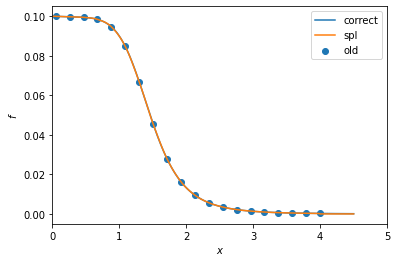

In [7]:
# test the function above 
import matplotlib.pyplot as plt

# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f$')
ax.set_xlim([0,5])
def testfu(x):
    return 1.0/(10.0+x**6)*np.exp(-0.01*x)

xold = np.linspace(0.05,4,20)
                
fold =testfu(xold)
                
                
# xnew = np.outer(np.linspace(0.01,4.5,5),np.linspace(0.01,4.5,10))
xnew = np.linspace(0.01,4.5,200) 
fnew=testfu(xnew)

spl=Cubherm.spl(xold,xnew)
fspl=np.zeros(xnew.shape,dtype=np.double)
for n in range(len(xold)):
  fspl=fspl+spl[n,:]*fold[n]

xprint=xnew.reshape(-1)
fsplprint=fspl.reshape(-1)
fprint=fnew.reshape(-1)


ax.scatter(xold,fold,label=r"old")
ax.plot(xprint,fprint,label=r"correct")
ax.plot(xprint,fsplprint,label=r"spl")

ax.legend(loc="best")
    
fig.savefig("spltest.pdf")    

for i in range(0,len(fprint),8):  
  print("{0:15.6e}  {1:15.6e} {2:15.6e} ".format(xprint[i],(fsplprint[i]-fprint[i])/fprint[i],fprint[i]))

Yes. Interpolation works!

### Three-Body kernel
For the three-body equation, we additionally need the permutation operator and the combination to the matrix $K$. This is implemented 
in an extension of the TwoBody class. The initialization needs to add a set of partial waves and a set of angular grid points for the permutation operators and prepares the $G$ functions and 
spline functions. 

In [8]:
# definition of a ThreeBody class for the calculation of bound states
from numpy.polynomial.legendre import leggauss
from scipy.special import sph_harm
from sympy.physics.quantum.cg import CG
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_9j


class ThreeBody(TwoBodyTMat):
    """Provides routines for the implementation of the permutation operator and application of the bound state kernel."""
        
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, 
                            nq1=20, nq2=10, qa=1.0, qb=5.0, qc=20.0, 
                            nx=12,
                            mass=938.92,l12max=6,j12max=5,l3max=5, j3min=1,j3max=1, parimin=1, parimax=1, 
                            tau3min=1,tau3max=1,nr1=20, potential=0,nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            nrho1=20, nrho2=10, rhoa=1.0, rhob=5.0, rhoc=20.0, 
                            np1four=200,np2four=100):     
        """Initializes the permutation operator for the three-body calculation and prepares application of Faddeev kernel.
        
           Parameters: 
           
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of p grid points in interval [0,pb] 
           np2 -- number of p grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           nq1 -- number of q grid points in interval [0,qb] 
           nq2 -- number of q grid points in interval [qb,qc]
           qa  -- half of np1 points are in interval [0,qa]
           qb  -- interval boundary as defined above 
           qc  -- upper integration boundary for the solution of the integral equation 
           
           nx -- angular grid points for the permutation operator
           
           mass -- particle mass of the three identical bosons in MeV
           
           nr1 -- number of r (related to p) points in interval [0,rb] 
           nr2 -- number of r (related to p) points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,ra]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           nrho1 -- number of rho (related to q) points in interval [0,rhob] 
           nrho2 -- number of rho (related to q) points in interval [rhob,rhoc]
           rhoa  -- half of np1 points are in interval [0,rhoa]
           rhob  -- interval boundary as defined above 
           rhoc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p or q  points in interval [0,pb] or[0,qb]   for Fourier trafo
           np2four -- number of p or q points in interval [pb,pc] or [qb,qc] for Fourier trafo
           
           lmax  -- maximal two-body angular momentum to be taken into account    
           bl    -- total orbital angular momentum L ("big l")           
        """
        # first initialize the tmatrix class (do not calc the tmatrix yet)
        super().__init__(pot,np1,np2,pa,pb,pc,nq1,nq2,qa,qb,qc,
                         mass,l12max,j12max,potential,
                         nr1,nr2,ra,rb,rc,nrho1,nrho2,rhoa,rhob,rhoc,
                         np1four,np2four)
        
        # prepare angular grid points for the permutation operator 
        self.nx=nx
        self.xp,self.xw = leggauss(nx)
        
        # prepare partial wave channels for total angular momentum bl
        # the preparation of a table of allowed combinations is useful 
        # for L != 0 (then l=l12 and lam=l3 can be different from each other)
        self.l3max=l3max
        self.I3max=2*l3max+1
        self.l12max=l12max
        self.lmax=l12max
        self.j12max=j12max
        self.j3min=j3min
        self.j3max=j3max
        self.parimin=parimin
        self.parimax=self.l3max
        self.lammax=self.l3max
        self.tau3min=tau3min
        self.tau3max=tau3max
        self.blmax=self.l12max+self.l3max
        
        #Here we do the bookkeeping for the three body problem
        nalpha3N=0 
        for tau3 in range(self.tau3min,self.tau3max+2,2):
            for j3 in range(self.j3min,self.j3max+2,2):
                for pari in range(self.parimin,self.parimax+2,2):
                    for I3 in range(1,self.I3max+2,2):
                        for l3 in range(np.int(abs(I3-1)/2),min(np.int((I3+1)/2),self.l3max)+1):
                            for alphaNN in range(self.nalphaNN):
                                l12=self.qnalpha[0,alphaNN]
                                s12=self.qnalpha[1,alphaNN]
                                j12=self.qnalpha[2,alphaNN]
                                t12=self.qnalpha[3,alphaNN]
                                if(pari==(-1)**(l12+l3) and j12>=np.int(abs(I3-j3)/2) and j12<=np.int(abs(I3+j3)/2)
                                      and t12>=np.int(abs(tau3-1)/2) and t12<=np.int((tau3+1)/2)):
                                    nalpha3N+=1
        self.qnalpha3N=np.zeros((10,nalpha3N),dtype=np.int)
        nalpha3N=0
        alpha=0
        for tau3 in range(self.tau3min,self.tau3max+2,2):
            for j3 in range(self.j3min,self.j3max+2,2):
                for pari in range(self.parimin,self.parimax+2,2):
                    for I3 in range(1,self.I3max+2,2):
                        for l3 in range(np.int(abs(I3-1)/2),min(np.int((I3+1)/2),self.l3max)+1):
                            for alphaNN in range(self.nalphaNN):
                                l12=self.qnalpha[0,alphaNN]
                                s12=self.qnalpha[1,alphaNN]
                                j12=self.qnalpha[2,alphaNN]
                                t12=self.qnalpha[3,alphaNN]
                                if(pari==(-1)**(l12+l3) and j12>=np.int(abs(I3-j3)/2) and j12<=np.int(abs(I3+j3)/2)
                                      and t12>=np.int(abs(tau3-1)/2) and t12<=np.int((tau3+1)/2)):
                                    self.qnalpha3N[0,nalpha3N]=l12
                                    self.qnalpha3N[1,nalpha3N]=s12
                                    self.qnalpha3N[2,nalpha3N]=j12
                                    self.qnalpha3N[3,nalpha3N]=l3
                                    self.qnalpha3N[4,nalpha3N]=I3
                                    self.qnalpha3N[5,nalpha3N]=j3
                                    self.qnalpha3N[6,nalpha3N]=alphaNN
                                    self.qnalpha3N[7,nalpha3N]=pari
                                    self.qnalpha3N[8,nalpha3N]=t12
                                    self.qnalpha3N[9,nalpha3N]=tau3
                                    nalpha3N +=1
        self.nalpha3N=nalpha3N
        print('Number of coupled states(3-Body)', nalpha3N)
                                
        
        
        #print("{0:>10s}   {1:>6s}    {2:>6s}    {3:>6s}      {4:>6s}    {5:>6s}      {6:>6s}   {7:>6s}   {8:>6s}".format("alpha3N","l12","s12","J12","l3","I3","pari", "t12", "tau3"))
        #for alpha in range(self.nalpha3N):
        #    print("{0:10d}   {1:6d}    {2:6d}    {3:6d}   {4:6d}    {5:6d}   {6:6d}   {7:6d}   {8:6d}   {9:6d}  {10:6d}".format(alpha,self.qnalpha3N[0,alpha],
        #       self.qnalpha3N[1,alpha],self.qnalpha3N[2,alpha],
        #       self.qnalpha3N[3,alpha],self.qnalpha3N[4,alpha],
        #       self.qnalpha3N[5,alpha],self.qnalpha3N[7,alpha],
        #       self.qnalpha3N[7,alpha],self.qnalpha3N[8,alpha],self.qnalpha3N[9,alpha]))
        # this prepares the G function and splines to be used for the preparation of the 
        # kernel later (pmat = permutation matrix)
        self.pmat=self._prep_perm()
        
    def _angle(self,px,py,pz):
        """Auxiliary routine to determine magnitude, phi, and theta of three component vector. 
        
           Parameters:
           px,py,pz -- cartesian components of a vector 
           
           returns magntitude, theta and phi angles.
        """
    
        pmag=np.sqrt(px**2+py**2+pz**2)
        theta=np.where(pmag!=0.0,np.arccos(pz/pmag),0.0)
             
        phi=np.empty(theta.shape,dtype=np.double) # copy shape of theta to phi 

        # prepare bool arrays for px,py > 0 < 0  with shape of phi 
        
        pxgt0=(px>0.0)    # test 
        pxlt0=(px<0.0)    # test 
        pxeq0=(px==0)   # test 
        
        phi=np.where(pxgt0,np.arctan(py/px),phi)
        phi=np.where(pxlt0,m.pi+np.arctan(py/px),phi)
        phi=np.where(pxeq0,np.sign(py)*m.pi/2,phi)
        
        phi=np.where(phi<0.0,2*m.pi+phi,phi)
            
        return pmag,theta,phi     
    
    
    def _lmindx(self,l,m):
        """Combined unique index for l and m.
        
           Nice trick: since quantum numbers lm are linked to each other, this combined 
           index allows one to store the results depending on lm using the memory more efficiently. 
        """        
        return l**2+l+m
      
        
    def _prep_perm(self):
        """Prepares and return an array for the application of the permutation operator.

           The matrix is based on G_{alpha,alphap}(q,qp,x) and is combined to be
           directly applicable to be summed  with tmatrix.
        """

        # prepare shifted momenta and angles for the symmetric permutation
        pip=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        pi=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)

        thetap=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        phip=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        theta=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        phi=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        thetapp=np.empty((self.nx),dtype=np.double)

        for ix in range(self.nx):
          xval=self.xp[ix]
          thetapp[ix]=np.arccos(xval)
          for jq in range(self.nqpoints):
            qpval=self.qgrid[jq]
            for iq in range(self.nqpoints):
              qval=self.qgrid[iq]

              px=qpval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=0.5*qval+qpval*xval
              pi[iq,jq,ix],theta[iq,jq,ix],phi[iq,jq,ix]=self._angle(px,py,pz)

              pxtest=pi[iq,jq,ix]*np.sin(theta[iq,jq,ix])*np.cos(phi[iq,jq,ix])
              pytest=0.0
              pztest=pi[iq,jq,ix]*np.cos(theta[iq,jq,ix])

              #if(np.abs(pxtest-px)>1E-6 or np.abs(pytest-py)>1E-6 or np.abs(pztest-pz)>1E-6):
                #print("pi:",px,py,pz,pxtest,pytest,pztest,pi[iq,jq,ix],theta[iq,jq,ix],phi[iq,jq,ix])

              px=-0.5*qpval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=-qval-0.5*qpval*xval
              pip[iq,jq,ix],thetap[iq,jq,ix],phip[iq,jq,ix]=self._angle(px,py,pz)

              pxtest=pip[iq,jq,ix]*np.sin(thetap[iq,jq,ix])*np.cos(phip[iq,jq,ix])
              pytest=0.0
              pztest=pip[iq,jq,ix]*np.cos(thetap[iq,jq,ix])

              #if(np.abs(pxtest-px)>1E-6 or np.abs(pytest-py)>1E-6 or np.abs(pztest-pz)>1E-6):
                #print("pip:",px,py,pz,pxtest,pytest,pztest,pip[iq,jq,ix],thetap[iq,jq,ix],phip[iq,jq,ix])

        # prepare spherical harmonics and store based on lmindx
        # number of lam,mu und l,mu combinations: lam=l3, l=l12
        nlamindx=self._lmindx(self.lammax,self.lammax)+1
        nlindx=self._lmindx(self.l12max,self.l12max)+1

        # array for Y_{lam mu}(hat qp) (real is sufficient since phi=0)
        ylam=np.empty((nlamindx,self.nx),dtype=np.double)
        for lam in range(self.lammax+1):
          for mu in range(-lam,lam+1):
            ylam[self._lmindx(lam,mu),:]=np.real(sph_harm(mu,lam, 0, thetapp))


        # array for Y_{l mu}(-q-0.5qp) (real is sufficient since phi=0)
        yl=np.empty((nlindx,self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        for l in range(self.l12max+1):
          for mu in range(-l,l+1):
            yl[self._lmindx(l,mu),:,:,:]=np.real(sph_harm(mu,l, phip, thetap))

        # array for Y*_{l mu}(0.5q+qp) (real is sufficient since phi=0)
        ystarl=np.empty((nlindx,self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        for l in range(self.l12max+1):
          for mu in range(-l,l+1):
            ystarl[self._lmindx(l,mu),:,:,:]=np.real(sph_harm(mu,l, phi, theta))

        # now prepare the necessary Clebsch-Gordan coefficients
        # we need (l lam L, M 0 M)  and (l lam L,mu M-mu,M)
        # I assume that L is smaller than the lmax or lammax therefore M=-L,L
        # the smallest index for storage

        cg=np.zeros((self.nalpha3N,self.blmax+1, 2*self.blmax+1+3),dtype=np.double)
        cgp=np.zeros((self.nalpha3N,self.blmax+1, 2*self.blmax+1+3,2*self.l12max+1+3),dtype=np.double)

        for alpha3N in range(self.nalpha3N):  # go through allowed l,lam combinations
            l =self.qnalpha3N[0,alpha3N]   #l12
            lam =self.qnalpha3N[3,alpha3N]  #l3
            for bl in range(abs(l -lam), l + lam+1):
                for bm in range(-bl,bl+1):
                  cg[alpha3N,bl,bm+bl]=float(CG(l,bm,lam,0,bl,bm).doit())

                  for mu in range(-l,l+1):
                     cgp[alpha3N,bl,bm+bl,mu+l]=float(CG(l,mu,lam,bm-mu,bl,bm).doit())


        # now we can perform the mu summation for the combination of coupled spherical harmonics
        ylylam=np.zeros((self.nalpha3N,self.blmax+1,2*self.blmax+3,self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        for alpha3N  in range(self.nalpha3N):  # go through allowed l,lam combinations
          l =self.qnalpha3N[0,alpha3N]
          lam =self.qnalpha3N[3,alpha3N]

          for bl in range(abs(l -lam),l+lam+1):
            for bm in range(-bl,bl+1):
             for mu in range(-l,l+1):
               lmindx=self._lmindx(l,mu)
               if abs(bm-mu)<=lam:
                lamindx=self._lmindx(lam,bm-mu)
                for ix in range(self.nx):
                   ylylam[alpha3N,bl,bm+ bl,:,:,ix]+=cgp[alpha3N,bl,bm+bl,mu+l]*yl[lmindx,:,:,ix]*ylam[lamindx,ix]

        # bm summation then gives Gtemp
        gfunc_temp=np.zeros((self.nalpha3N,self.nalpha3N,self.blmax+1,self.nqpoints,\
                self.nqpoints,self.nx),dtype=np.double)

        for alpha3N in range(self.nalpha3N):  # go through allowed l,lam combinations
          l12 =self.qnalpha3N[0,alpha3N]
          lam =self.qnalpha3N[3,alpha3N]
          j3 = self.qnalpha3N[5,alpha3N]
          pair = self.qnalpha3N[7,alpha3N]

          for alpha3Np in range(self.nalpha3N):  # go through allowed l,lam combinations
              if (j3  == self.qnalpha3N[5,alpha3Np] and pair ==self.qnalpha3N[7,alpha3Np]):

                for bl in range(abs(lam -l12),lam+l12+1):
                  for bm in range(-bl,bl+1):
                    if(abs(bm)<=l12):
                      lmindx=self._lmindx(l12,bm)
                      gfunc_temp[alpha3N,alpha3Np,bl,:,:,:]+=8*m.pi**2*np.sqrt((2*lam+1)/(4*m.pi)) \
                      *ystarl[lmindx,:,:,:]*ylylam[alpha3Np,bl,bm+bl,:,:,:] \
                      *cg[alpha3N,bl,bm+ bl]

        #now summation over L and S
        gfunc=np.zeros((self.nalpha3N,self.nalpha3N,self.nqpoints,\
                self.nqpoints,self.nx),dtype=np.double)

        for alpha3N in range(self.nalpha3N):  # go through allowed l,lam combinations
          l =self.qnalpha3N[0,alpha3N]
          S12=self.qnalpha3N[1,alpha3N]
          j12 =self.qnalpha3N[2,alpha3N]

          lam =self.qnalpha3N[3,alpha3N]
          I3 =self.qnalpha3N[4,alpha3N]
          j3 = self.qnalpha3N[5,alpha3N]
          pari = self.qnalpha3N[7,alpha3N]
          t12 = self.qnalpha3N[8,alpha3N]
          tau3 = self.qnalpha3N[9,alpha3N]

          for alpha3Np in range(self.nalpha3N):  # go through allowed l,lam combinations
              lp =self.qnalpha3N[0,alpha3Np]
              S12p=self.qnalpha3N[1,alpha3Np]
              j12p =self.qnalpha3N[2,alpha3Np]

              lamp =self.qnalpha3N[3,alpha3Np]
              I3p =self.qnalpha3N[4,alpha3Np]
              j3p = self.qnalpha3N[5,alpha3Np]
              parip = self.qnalpha3N[7,alpha3Np]

              t12p = self.qnalpha3N[8,alpha3Np]
              tau3p = self.qnalpha3N[9,alpha3Np]

              factor= (-1)**(S12+t12)*np.sqrt((2*j12+1) *(2*j12p+1)*(I3+1)*(I3p+1)*
                      (2*S12+1)*(2*S12p+1) *(2*t12+1)*(2*t12p+1))

              if (j3  == j3p and pari ==parip  and tau3 ==tau3p):
                for bl in range(abs(lam -l),lam+l+1):
                  for S in range(abs(2*S12 - 1),2 * S12 +3,2):
                      factor1 = factor * (S+1)

                      factor2=factor1* wigner_9j(l,S12,j12,lam,0.5,I3/2,bl,S/2,j3/2)*\
                                  wigner_9j(lp,S12p,j12p,lamp,0.5,I3p/2,bl,S/2,j3/2)*\
                                  wigner_6j(0.5,0.5,S12,0.5,S/2,S12p) * \
                                  wigner_6j(0.5,0.5,t12,0.5,tau3/2,t12p)

                      gfunc[alpha3N,alpha3Np,:,:,:] =  gfunc[alpha3N,alpha3Np,:,:,:] + \
                          factor2 * gfunc_temp[alpha3N,alpha3Np,bl,:,:,:]
        #  now we assume that there is a function on p on the left defined by p**l and on the right devided by p'**l'
        # that is interpolated using Cubherm to pi and pip

        # set spline elements based on grid points and shifted momenta
        splpi=Cubherm.spl(self.pgrid,pi)
        splpip=Cubherm.spl(self.pgrid,pip)

        # interpolation fspl=np.sum(spl*fold,axis=1) first axis is pgrid
        # prepare splines multiplied by p**l factors (splalpha also includes the integration weights for q' and x integral)

        splalpha=np.zeros((self.npoints*self.nqpoints*self.nalpha3N,self.nqpoints,self.nx),dtype=np.double)
        splalphap=np.zeros((self.npoints*self.nqpoints*self.nalpha3N,self.nqpoints,self.nx),dtype=np.double)


        for alpha in  range(self.nalpha3N):  # go through allowed l,lam combinations
          l=self.qnalpha3N[0,alpha]
          for ip in range(self.npoints):
           for iq in range(self.nqpoints):
             indxpmat=self.npoints*self.nqpoints*alpha+self.npoints*iq+ip
             for jq in range(self.nqpoints):

                 splalpha[indxpmat,jq,:]=splpi[ip,iq,jq,:]*(pi[iq,jq,:]/self.pgrid[ip])**l*self.xw[:]*self.qweight[jq]*self.qgrid[jq]**2
                 splalphap[indxpmat,jq,:]=splpip[ip,jq,iq,:]*(pip[jq,iq,:]/self.pgrid[ip])**l



        pmat=np.empty((self.npoints*self.nqpoints*self.nalpha3N,
            self.npoints*self.nqpoints*self.nalpha3N),dtype=np.double)

        for alpha in range(self.nalpha3N):  # go through allowed l,lam combinations
          for alphap in range(self.nalpha3N):  # go through allowed l,lam combinations
            for ip in range(self.npoints):
             for iq in range(self.nqpoints):
              indxpmat=self.npoints*self.nqpoints*alpha+self.npoints*iq+ip
              for jp in range(self.npoints):
               for jq in range(self.nqpoints):
                indxpmatp=self.npoints*self.nqpoints*alphap+self.npoints*jq+jp
                pmat[indxpmat,indxpmatp]=np.sum(splalpha[indxpmat,jq,:]
                              *gfunc[alpha,alphap,iq,jq,:]
                              *splalphap[indxpmatp,iq,:])

        return pmat

    def prep_faddeev(self,ener):
        """Prepares the Faddeev kernel as a matrix using only two-body interactions.

           Parameter:
           ener -- three-body energy in fm-1
        """

        # get tmatrix for given energy
        tmat=self.prep_tmat(ener)        # tmat[j,i,tindex,ie]

        # use matrix multiplication of preprepared permutation matrix
        # self.pmat[indxpmat,indxpmatp] contains permutation matrix
        # indexpmat is alpha,iq,ip

        self.kfadmat=np.zeros(self.pmat.shape,dtype=np.double)

        for alpha3N in range(self.nalpha3N):
          l=self.qnalpha3N[0,alpha3N]
          l3 = self.qnalpha3N[2,alpha3N]
          I3 = self.qnalpha3N[4,alpha3N]
          alphaNN = self.qnalpha3N[6,alpha3N]

          for alpha3Np in range(self.nalpha3N):
              if ( l3 ==self.qnalpha3N[2,alpha3Np] and  \
                      I3 ==self.qnalpha3N[4,alpha3Np]):

                  alphaNNp = self.qnalpha3N[6,alpha3Np]

                  tindex = self.abarNN_alpha[alphaNN,alphaNNp]

                  if (tindex >= 0):
                    for iq in range(self.nqpoints):
                      for ip in range(self.npoints):
                        indxkmat=ip+self.npoints*iq+self.npoints*self.nqpoints*alpha3N
                        for jp in range(self.npoints):
                          indxpmat=jp+self.npoints*iq+self.npoints*self.nqpoints*alpha3Np
                          self.kfadmat[indxkmat,:]+=tmat[tindex,iq,ip,jp]*2*self.pmat[indxpmat,:]  # why multiply by 2?

        # now multiply with G0

        G0=np.empty((self.nqpoints,self.npoints),dtype=np.double)
        for iq in range(self.nqpoints):
          for ip in range(self.npoints):
            G0[iq,ip]=1.0/(ener-0.75*self.qgrid[iq]**2/self.mass-self.pgrid[ip]**2/self.mass )

        for alpha in range(self.nalpha3N):
          for iq in range(self.nqpoints):
            for ip in range(self.npoints):
              indxkmat=ip+self.npoints*iq+self.npoints*self.nqpoints*alpha
              self.kfadmat[indxkmat,:]*=G0[iq,ip]

# set up set of equations and calculate eigenvalues

    def eigv(self,E,neigv):
      """Solve three-body Faddev equation and return n-th eigenvalue and Faddeev component.

         Parameters:
         E -- energy used in the integral equation in fm**-1
         neigv -- number of the eigenvalue to be used"""

    # set up the matrix for the Faddeev equations
      self.prep_faddeev(E)

    # determine eigenvalues using numpy's eig method
      evalue,evec=np.linalg.eig(self.kfadmat)
      #print('E', E)

    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic
      evalue=np.real(evalue)

    # remove neigv-1 largest eigenvalues
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0

    # take the next one
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
      #print('maxpos, eigb', maxpos, eigv)

    # define solution as unnormalized Faddeev component
      fadcomp=np.real(evec[:,maxpos])

    # and normalize using permutation again
      fadtmp=2.0*self.pmat.dot(fadcomp)

      norm=0.0
      for alpha in range(self.nalpha3N):
        for iq in range(self.nqpoints):
          for ip in range(self.npoints):
            indxkmat=ip+self.npoints*iq+self.npoints*self.nqpoints*alpha
            norm+=fadcomp[indxkmat]*fadtmp[indxkmat]*self.qweight[iq]*self.qgrid[iq]**2

      fadcomp=fadcomp.reshape((self.nalpha3N,self.nqpoints,self.npoints))
      norm+=self.skalp(fadcomp,fadcomp)
      norm*=3.0

      fadcomp=(1/np.sqrt(norm))*fadcomp

      return eigv,fadcomp

    def esearch(self,neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8):
        """Perform search for energy using the secant method.

           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged

           Energies are given in fm**-1. """

        # determine eigenvalues for starting energies
        eta1,fadcomp=self.eigv(e1,neigv)
        eta2,fadcomp=self.eigv(e2,neigv)

        while abs(e1-e2) > tol:
          # get new estimate (taking upper value into account)
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2)
          enew=min(elow,enew)

          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,fadcomp=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta

        return e1,eta1,fadcomp

    # the following methods are only useful for testing at this point and can be
    # ignored at first reading

    def faddeev(self,psiin,ener):
        """Applies the Faddeev kernel using only two-body interactions.

           Parameter:
           psiin -- incoming Faddeev component
           ener -- three-body energy in fm-1

        """

        # use matrix multiplication of preprepared permutation matrix
        psitmp=2.0*self.pmat.dot(psiin.reshape(-1)).reshape(psiin.shape)   # note a factor of two here

        # get tmatrix for given energy
        tmat=self.prep_tmat(ener)

        psiout=np.empty(psiin.shape)

        for alpha3N in range(self.nalpha3N):
          l=self.qnalpha3N[0,alpha3N]
          l3 = self.qnalpha3N[2,alpha3N]
          I3 = self.qnalpha3N[4,alpha3N]
          alphaNN = self.qnalpha3N[6,alpha3N]

          for alpha3Np in range(self.nalpha3N):
              if ( l3 ==self.qnalpha3N[2,alpha3Np] and  \
                      I3 ==self.qnalpha3N[4,alpha3Np]):
                  alphaNNp = self.qnalpha3N[6,alpha3Np]

                  tindex = self.abarNN_alpha[alphaNN,alphaNNp]

                  if (tindex >= 0):
                      for iq in range(self.nqpoints):
                        for ip in range(self.npoints):
                          for ipp in range(self.npoints):
                             psiout[alpha3N,iq,ip] +=tmat[ip,ipp,tindex,iq]*psitmp[alpha3Np,iq,ipp]

        # now multiply with G0

        G0=np.empty((self.nqpoints,self.npoints),dtype=np.double)
        for iq in range(self.nqpoints):
          for ip in range(self.npoints):
            G0[iq,ip]=1.0/(ener-0.75*self.qgrid[iq]**2/self.mass-self.pgrid[ip]**2/self.mass )

        for alpha in range(self.nalpha3N):
          psiout[alpha,:,:]=psiout[alpha,:,:]*G0

        return psiout

    def applyperm(self,psiin):
        """Application of 1+P operator using the permutation operator based on right-hand interpolations."""

        # use matrix multiplication of preprepared permutation matrix
        # to get (1+P) psiin
        psiout=2.0*self.pwfmat.dot(psiin.reshape(-1)).reshape(psiin.shape)
        psiout+=psiin

        return psiout

    def calc_ekin(self,psifad,psiwf):
        """Calculates and print the kinetic energy in two ways.

           Calculates 3 < psi | T | Psi > (where Psi= (1+P) psi)
           and <Psi | T | Psi >.

           Returns ekin and ekinfad in fm**-1.
        """

        T=np.empty((self.nqpoints,self.npoints),dtype=np.double)
        for iq in range(self.nqpoints):
          for ip in range(self.npoints):
            T[iq,ip]=(0.75*self.qgrid[iq]**2/self.mass+self.pgrid[ip]**2/self.mass)  \
                       *self.qgrid[iq]**2*self.qweight[iq]  \
                       *self.pgrid[ip]**2*self.pweight[ip]

        ekin=np.sum(psiwf**2*T)
        ekinfad=3.0*np.sum(psiwf*T*psifad)

        return ekin,ekinfad   #ekin == ekinfad? why?

    def calc_vpot(self,psiwf):
        """Calculates expectation value of the potential energy.

           Returns the potential energy in fm**-1.
        """

        # first prepare potential matrix elements
        # including the integration weights for p integrations (left and right)
        vpot=np.empty((self.numabarNN,self.npoints,self.npoints),dtype=np.double)

        VNN = self.VNNpot()   # VNN(p12,p12p,abarNN_index)

        for vindex in range(self.numabarNN):
          for ip in range(self.npoints):
            for jp in range(self.npoints):
              vpot[vindex,ip,jp]=VNN[self.pgrid[ip],self.pgrid[jp],vindex] \
                             *self.pgrid[ip]**2*self.pweight[ip] \
                             *self.pgrid[jp]**2*self.pweight[jp]


        epot=0.0

        for alpha3N in range(self.nalpha3N):
          l=self.qnalpha3N[0,alpha3N]
          l3 = self.qnalpha3N[2,alpha3N]
          I3 = self.qnalpha3N[4,alpha3N]
          alphaNN = self.qnalpha3N[6,alpha3N]

          for alpha3Np in range(self.nalpha3N):
              if ( l3 ==self.qnalpha3N[2,alpha3Np] and  \
                      I3 ==self.qnalpha3N[4,alpha3Np]):
                  alphaNNp = self.qnalpha3N[6,alpha3Np]

                  tindex = self.abarNN_alpha[alphaNN,alphaNNp]
                  if (tindex >= 0):
                    for iq in range(self.nqpoints):
                      for ip in range(self.npoints):
                         epot+=np.sum(vpot[tindex,ip,:]*psiwf[alpha3Np,iq,:]) \
                              *psiwf[alpha3N,iq,ip] \
                              *self.qgrid[iq]**2*self.qweight[iq]
        epot=3*epot

        return  epot

    # the following routines are useful for testing the code.

    def skalp(self,psi1,psi2):
        """Calculate scalar product of two wave functions."""

        # multiply with integation weights
        psitmp=np.zeros((self.nalpha3N,self.nqpoints,self.npoints),dtype=np.double)
        for alpha in range(self.nalpha3N):
         for iq in range(self.nqpoints):
          for ip in range(self.npoints):
           psitmp[alpha,iq,ip]=psi2[alpha,iq,ip] \
                                   *self.pweight[ip]*self.pgrid[ip]**2  \
                                   *self.qweight[iq]*self.qgrid[iq]**2
        return np.sum(psi1*psitmp)

    def testperm(self,psi1,psi2):
        """Test permutation matrix."""

        # first scalar product without permutation
        product=self.skalp(psi1,psi2)

        # now apply permutation
        psitmp=self.pmat.dot(psi2.reshape(-1)).reshape(psi2.shape)

        # and build the scalar product (only q integration is necessary)
        for iq in range(self.nqpoints):
           psitmp[:,iq,:] = psitmp[:,iq,:] * self.qgrid[iq]**2*self.qweight[iq]

        permprod=np.sum(psitmp*psi1)

        print("Permutation test:  {0:15.6e}   {1:15.6e}".format(product,permprod))

    def testfu(self):
        """Prepares a fully symmetrical wave function."""

        psitmp=np.zeros((self.nalpha3N,self.nqpoints,self.npoints),dtype=np.double)
        for alpha3N in range(self.nalpha3N):
          l=self.qnalpha3N[0,alpha3N]
          l3 = self.qnalpha3N[2,alpha3N]
          if (l==0 and l3==0):
           for iq in range(self.nqpoints):
            for ip in range(self.npoints):
             x=self.pgrid[ip]**2 +0.75*self.qgrid[iq]**2
             psitmp[alpha3N,iq,ip]=np.exp(-0.05*x)/(0.05*x**2+10.0)


        return psitmp

    def printwf(self,psi):
        """Prints wave function."""

        psitest=psi.reshape(-1)
        for j in range(self.npoints*self.nqpoints*self.nalpha3N):
            alphap=j//(self.npoints*self.nqpoints)
            jq=(j-alphap*self.npoints*self.nqpoints)//self.npoints
            jp=(j-self.npoints*self.nqpoints*alphap-self.npoints*jq)#

            print("{0:s}   {1:4d}    {2:4d} {3:4d} {4:4d}       {5:15.6e}  {6:15.6e}".format("testfu",j,jp,jq,alphap,psitest[j],psi[alphap,jq,jp]))


    def comparewf(self,psi1,psi2,tolrel,tolabs):
        """Compares two wave functions."""

        for j in range(self.npoints*self.nqpoints*self.nalpha3N):
            alphap=j//(self.npoints*self.nqpoints)
            jq=(j-alphap*self.npoints*self.nqpoints)//self.npoints
            jp=(j-self.npoints*self.nqpoints*alphap-self.npoints*jq)

            if abs(psi1[alphap,jq,jp]-psi2[alphap,jq,jp])>tolabs \
               or abs(psi1[alphap,jq,jp]-psi2[alphap,jq,jp])/max(abs(psi1[alphap,jq,jp]),tolabs) > tolrel:

              print("{0:s}   {1:4d}    {2:4d} {3:4d} {4:4d}       {5:15.6e}  {6:15.6e}    {7:15.6e}".format("Compare:",j,jp,jq,alphap,
                                        psi1[alphap,jq,jp],psi2[alphap,jq,jp],(psi1[alphap,jq,jp]-psi2[alphap,jq,jp])/psi1[alphap,jq,jp]))

In [9]:
#this is to check for the parameters. We want a bindingenergy -2.225 in the ^3S_1 state(j12,s12=1 and t=0) and no bound state 
# in ^1S_0(j12,s12=0 and t=1)
a=0
#since we do not want to do this calculation everytime, just change a if you want to do it
if(a==1):
    #pot=OBEpot(nx=24,mpi=138.0,C0=-0.098,A=-1.0/6.474860194946856,cutoff=300.)
    parasets=[700.0, 0.020167185806378923]
    pot=Onepi(cutoff=1000.0,nx=12,C0=-0.146, C1=0.2091,mpi=138.0)

    solver=TwoBody(pot=pot,np1=20,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,j12=1,s12=1,t12=0,
                        nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0,
                        np1four=400,np2four=200)
    ener,lam,pmom,wf=solver.esearch(neigv=1,e1=-2.0/TwoBody.hbarc,e2=-2.5/TwoBody.hbarc)
    rp,wfr=solver.fourier(wf)
    print("{0:15.6e}   {1:15.6e}  ".format(ener*TwoBody.hbarc,lam))


In [10]:
#Now we come to the calculation. The calculation takes some time!!!
para=[700.0, 0.020167185806378923]
#para=[1200.0, 0.03431611357447293]

#choose the right potential 
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
#pot=Onepi(cutoff=500.0,nx=12,C0=-0.196, C1=-0.187035,mpi=138.0)

# Potential=1->OPE-Potential and potential=0->OBE-Potential
kernel=ThreeBody(pot,nx=10,np1=15,np2=10,nq1=15,nq2=10,l12max=2,j12max=3,l3max=2,j3min=1,
           j3max=1,parimin=1,parimax=1,tau3min=1,tau3max=1,potential=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)



Number of coupled states(3-Body) 16
   alpha3N      l12       s12       J12          l3        I3        pari      t12     tau3
         0        0         0         0        0         1        1        1        1        1       1
         1        0         1         1        0         1        1        1        1        0       1
         2        2         1         1        0         1        1        1        1        0       1
         3        1         1         0        1         1        1        1        1        1       1
         4        1         0         1        1         1        1        1        1        0       1
         5        1         1         1        1         1        1        1        1        1       1
         6        1         0         1        1         3        1        1        1        0       1
         7        1         1         1        1         3        1        1        1        1       1
         8        1         1         2        1